In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from unidecode import unidecode
from tqdm import tqdm
import json
import re
from IPython.display import HTML
import itertools

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Funciones y variables globales</h3>

In [2]:
# archivo conteos y agrupaciones a doc. original
wb_original_results = './Cambios_aplicados/wb_original_results.xlsx'
wb_final_results = './Cambios_aplicados/wb_final_results.xlsx'

# wb libro regs únicos 
wb_regs_unicos = './Cambios_aplicados/wb_regs_unicos.xlsx'

# libro a analizar
# variables files
file_to_analize = './Sitios SEMS.xlsx'

In [3]:
# funciones globales

def save_df_changes(df_object, file_name='Libro_cambios_aplicados'):
  """
  Save workbooks in the default path with xlsx extention
  
	Args:
			df_object (_type_): dataframe to save as file
			file_name (str, optional): filename NO extention
	"""
  try:
    df_object.to_excel(f'./Cambios_aplicados/{file_name}.xlsx', index=None)
    print(f'Se ha exportado el libro: {file_name}.xlsx\nRuta del archivo: "Cambios_aplicados -> {file_name}.xlsx"')
  except PermissionError:
    print("el libro no se pudo exportar, debido a que el libro exportado anteriormente esta abierto, se debe cerrar.")


def sin_ascentos(nombre: str)-> str:
  """
  reemplazar tildes en palabras
  """
  abc = [
    ('Á', 'A'), ('É', 'E'), ('Í', 'I'), ('Ó', 'O'), ('Ú', 'U'), ('Ü', 'U'), 
    ('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ü', 'u')
    ]
  for a in abc:
    nombre = nombre.replace(a[0], a[1])
  return nombre

def save_df_in_sheet_from_workbook(dataframe, sheetname, workbookname):
  """
  Save a DataFrame into an Excel worksheet inside a specified Excel file.
  
  Arguments:
  - dataframe: The DataFrame to be saved into the Excel worksheet
  - sheetname: The name of the Excel worksheet in which the DataFrame will be written
  - workbookname: The name of the Excel file in which the DataFrame will be saved
  """
  try:
    with pd.ExcelWriter(workbookname, mode='a') as writer:
      dataframe.to_excel(writer, sheet_name=sheetname, index=None)
  except FileNotFoundError:
    with pd.ExcelWriter(workbookname) as writer:
      dataframe.to_excel(writer, sheet_name=sheetname, index=None)


In [4]:
# cargar en memoria el archivo de excel
data = pd.read_excel(io=file_to_analize, sheet_name=0, dtype={'Código postal*': object})

# crear dataframe
df = pd.DataFrame(data)

# eliminar data despues de convertirla en un dataframe
del data

In [5]:
# lr_df -> última fila de dataframe
lr = df.shape[0]

In [6]:
display(HTML(f'<h2 style="color: #fb8500;">El archivo tiene tiene {"{:,}".format(lr)} registros y {df.shape[1]} columnas</h2>'))

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Columnas Clave Dependencia (1) y Dependencia (2) </h3>

In [7]:
# importación del catálogo de ramos
tRamos = pd.read_csv('./Compact_inegi_dbLocs/ramo.csv')
lst_ramos = tRamos["cve_ramo"].to_list()
lst_desc_ramos = tRamos['descripcion'].to_list()
dictRamosByID = dict(zip(lst_ramos, lst_desc_ramos))
dictRamosByDesc = dict(zip(lst_desc_ramos, lst_ramos))

In [8]:
# actualizar la columna de clave dependencia y dependencia 

def update_row(row):
    
    clv = row['Clave de la Dependencia*']
    dep = row['Dependencia*']
    
    # si el registro esta en la lista de claves pero el valor de diccionario no corresponde a la dependencia
    if clv in lst_ramos and dictRamosByID[clv] != dep:
        row['Dependencia*'] = dictRamosByID[clv]
    
    # si la clave no esta en la lista de ramos y la clave no es un valor vacio
    elif clv not in lst_ramos and clv not in [' ', '']:
        try:
            row['Dependencia*'] = dictRamosByID[clv]
            row['Clave de la Dependencia*'] = dictRamosByDesc[dep]
        except KeyError:
            row['Clave de la Dependencia*'] = ' '
    return row

df = df.apply(update_row, axis=1)


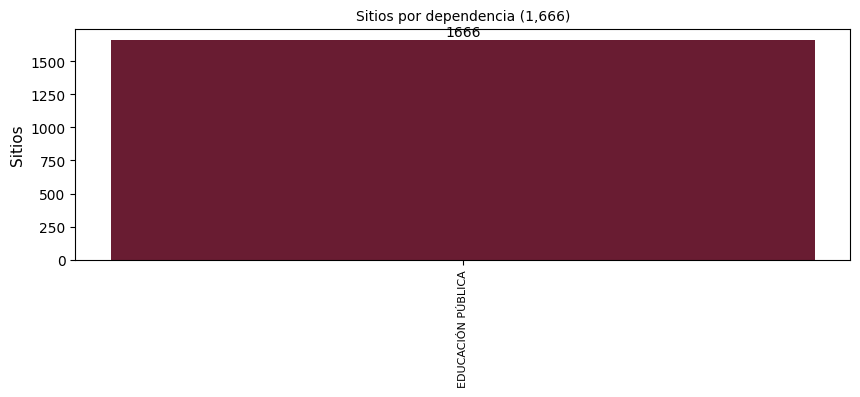

In [9]:
# conteo_regs_por_edo = df.groupby(by="Estado*").agg(conteo_regs=('Estado*', 'count')).reset_index().sort_values(by="conteo_regs", ascending=False)
# total_regs = conteo_regs_por_edo['conteo_regs'].sum()

df_group_dependencia = df.groupby(by="Dependencia*").agg(conteo_regs=('Dependencia*', 'count')).reset_index().sort_values(by='conteo_regs', ascending=False)
ttl_df_group_dependencia = '{:,}'.format(df_group_dependencia['conteo_regs'].sum())

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 3))

# Crear un gráfico de barras
ax.bar( df_group_dependencia['Dependencia*'], df_group_dependencia['conteo_regs'], width=0.5, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=10)
    
# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Sitios por dependencia ({ttl_df_group_dependencia})', fontdict={'fontsize': 10})
# ax.set_xlabel('Dependencias', fontsize=15)
ax.set_ylabel('Sitios', fontsize=11)

# Cambiar las etiquetas del eje x
ax.xaxis.set_major_locator(FixedLocator(range(len(df_group_dependencia))))
ax.xaxis.set_major_formatter(FixedFormatter(df_group_dependencia['Dependencia*']))

ax.set_xticklabels(labels=df_group_dependencia['Dependencia*'],fontsize=8)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

plt.show()

#eliminación de variables:

save_df_in_sheet_from_workbook(df_group_dependencia, 'gb_dependencia', wb_original_results) 
del df_group_dependencia


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Columna Clave de inmueble (3) </h3>

In [10]:
# hacer el contel de la clave inmueble, en primera instancia la clave de inmueble es una código único no vacio

# agrupacion de las claves y conteo de las repeticiones por cada clave
conteo_por_clvs = df.groupby(by='Clave del inmueble*').agg(regs_por_clave=('Clave del inmueble*', 'count')).reset_index()

# mantener solo las claves cuya repetición es mayor a una
conteo_por_clvs_duplicadas_clv =  conteo_por_clvs[conteo_por_clvs['regs_por_clave'] > 1].reset_index()

# segmentacion de conteo donde las claves repetidas estan vacias, solo saber el número de registros vacios
regs_sin_clv = conteo_por_clvs_duplicadas_clv[conteo_por_clvs_duplicadas_clv['Clave del inmueble*'] == " "]['regs_por_clave'][0]

# de las claves que no estan vacias mostrar las claves cuyo conteo es mayor a 1 y su valor es diferente a vacio [" " o ""]
regs_clv_dupl = conteo_por_clvs_duplicadas_clv[conteo_por_clvs_duplicadas_clv['Clave del inmueble*'] != " "]['regs_por_clave'].sum()

print(f'Registros SIN clave asignada: {regs_sin_clv}\nRegistros clave DUPLICADA: {regs_clv_dupl}\nTotal registros: {regs_sin_clv + regs_clv_dupl}')

Registros SIN clave asignada: 26
Registros clave DUPLICADA: 34
Total registros: 60


In [11]:
# agrupación de clave de inmueble y número de registros por clave
conteo_por_clvs_duplicadas_clv = conteo_por_clvs_duplicadas_clv[['Clave del inmueble*','regs_por_clave']]

# guardar el df agrupado [exportación]
try:
  save_df_in_sheet_from_workbook(conteo_por_clvs_duplicadas_clv, 'count_clv_duplicates', wb_original_results)
except ValueError:
  pass

# mostrar conteos del df
conteo_por_clvs_duplicadas_clv

,Clave del inmueble*,regs_por_clave
0,,26
1,01DBT0028N,2
2,03DPT0001H,2
3,04INM0650E,2
4,06DPT0181F,2
5,07INM09313,2
6,09DBT0155B,2
7,09DBT0156A,2
8,09DBT0171T,2
9,11DBT0001N,2


In [12]:
# creación de una lista de todos los registros duplicados por clave y reemplazo de los vacios por un None
lst_dupli_clv = [x if x != " " and x != "" else None for x in conteo_por_clvs_duplicadas_clv['Clave del inmueble*'].to_list()]

# segmentación del dataframe, filtrar solo los registros que estan repetidos en su clave de inmueble en la lista de claves duplicadas
df_regs_duplicados_by_clv = df[df['Clave del inmueble*'].isin(lst_dupli_clv)].sort_values(by='Clave del inmueble*')

# guardar el dataframe cuya clave esta en la lista de clave duplicadas y eliminar variables
save_df_in_sheet_from_workbook(df_regs_duplicados_by_clv, 'df_regs_dupli_in_file', wb_original_results)
del tRamos
del conteo_por_clvs_duplicadas_clv
del lst_desc_ramos
del conteo_por_clvs
del df_regs_duplicados_by_clv

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
		font-weight: bolder;
	}
</style>
<h3>Columna Tipo de inmuebles (5) </h3>

In [13]:
# importar catálogo de tipo de inmueble
tTipoInmueble = pd.read_csv('./Compact_inegi_dbLocs/tipo_inmueble.csv')

# crear lista de tipos de inmueble
lstTipoInmueble = tTipoInmueble['tipo_inmueble'].to_list()


In [14]:
def modificar_tipo_inmueble(clv_dep, dep, tp_inmueble):
  # si la clave de dependencias es igual a 11 y la dependencia es igual a EDUCACIÓN PÚBLICA 
  # entonces el tp_inmueble se reasigna a ESTABLECIMIENTO DE EDUCACIÓN
  if clv_dep == 11 and dep == "EDUCACIÓN PÚBLICA":
    tp_inmueble = "ESTABLECIMIENTO DE EDUCACIÓN"
  
  return tp_inmueble

# Aplica la función a todas las filas del dataframe
df["Tipo de inmuebles *"] = df.apply(lambda x: modificar_tipo_inmueble(x["Clave de la Dependencia*"], x["Dependencia*"], x["Tipo de inmuebles *"]), axis=1)


In [15]:
# eliminación de variables
del tTipoInmueble
del lstTipoInmueble
del dictRamosByDesc
del dictRamosByID
del regs_clv_dupl
del regs_sin_clv
del lst_dupli_clv
del lst_ramos
del fig

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
		font-weight: bolder;
	}
</style>
<h3>Columna Subtipo de Inmueble (6) </h3>

In [16]:
#import catálogo de subtipos de inmueble
tSubtipoInmueble = pd.read_csv('./Compact_inegi_dbLocs/subtipo_inmueble.csv')

In [17]:

#               .d8888b.        d8888  .d8888b.   .d88888b.       888     888 888b    888 8888888 .d8888b.   .d88888b.  
#              d88P  Y88b      d88888 d88P  Y88b d88P" "Y88b      888     888 8888b   888   888  d88P  Y88b d88P" "Y88b 
#              888    888     d88P888 Y88b.      888     888      888     888 88888b  888   888  888    888 888     888 
#              888           d88P 888  "Y888b.   888     888      888     888 888Y88b 888   888  888        888     888 
#              888          d88P  888     "Y88b. 888     888      888     888 888 Y88b888   888  888        888     888 
#              888    888  d88P   888       "888 888     888      888     888 888  Y88888   888  888    888 888     888 
#              Y88b  d88P d8888888888 Y88b  d88P Y88b. .d88P      Y88b. .d88P 888   Y8888   888  Y88b  d88P Y88b. .d88P 
#               "Y8888P" d88P     888  "Y8888P"   "Y88888P"        "Y88888P"  888    Y888 8888888 "Y8888P"   "Y88888P"  

def upgrade_subtipo_inmueble(nombre_inmueble, subtipo_inmueble):
  # CASO ESPECIAL YA QUE EL NOMBRE DE LOS INMUEBLES COMO TAL ESTABAN SEGMENTADA 
  # UNA PARTE EN EL CAMPO NOMBRE DE INMUEBLE Y OTRA PARTE EN EL CAMPO SUBTIPO DE INMUEBLE
  
  # primera depuración para homologar nombres de inmuebles 
  
  if subtipo_inmueble == 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)':
    nombre_inmueble = f'{subtipo_inmueble} {nombre_inmueble}'

  elif subtipo_inmueble == 'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO (CBTA)':
    nombre_inmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO - {nombre_inmueble}'

  elif subtipo_inmueble == 'EXTENSIÓN (CBTA)':
    nombre_inmueble = f'EXTENSIÓN {nombre_inmueble}'

  elif subtipo_inmueble == 'OFICINA ADMINISTRATIVA':
    nombre_inmueble = f'{nombre_inmueble} (Oficina administrativa)'

  elif subtipo_inmueble == 'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR (CETMAR)':
    nombre_inmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'CENTRO DE ESTUDIOS DE BACHILLERATO (CEB)':
    nombre_inmueble = f'CENTRO DE ESTUDIOS DE BACHILLERATO - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES (CETAC)':
    nombre_inmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'EXTENSIÓN (CETMAR)':
    nombre_inmueble = f'EXTENSIÓN {nombre_inmueble}'
  
  elif subtipo_inmueble == 'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL (CBTF)':
    nombre_inmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA (CONALEP)':
    nombre_inmueble = f'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'EXTENSIÓN CBTA' or subtipo_inmueble == 'EXTENSIÓN (CBTF)':
    nombre_inmueble = f'EXTENSIÓN - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL (UNCADER)':
    nombre_inmueble = f'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL - {nombre_inmueble}'
  
  elif 'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS' in subtipo_inmueble:
    nombre_inmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS -  {nombre_inmueble}'
  
  elif 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS' in subtipo_inmueble:
    nombre_inmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS - {nombre_inmueble}'

  elif subtipo_inmueble in ['CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO No. 167', 'EXTENSIÓN (CETAC)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA  DEL ESTADO DE TLAXCALA (CONALEP)', 'CENTRO MULTIMODAL DE ESTUDIOS CIENTIFICOS Y TECNOLOGICOS DEL MAR Y AGUAS CONTINENTALES', 'CENTRO DE INVESTIGACION DE RECURSOS NATURALES (CIRENA)', 'CENTRO DE BACHILLERATO TECNOLOGICO AGROPECUARIO NUM 191']:
    nombre_inmueble = f'{subtipo_inmueble} - {nombre_inmueble}'
  
  return nombre_inmueble

df['Nombre del inmueble*'] = df.apply(lambda x: upgrade_subtipo_inmueble(x['Nombre del inmueble*'], x['Subtipo de inmueble *']), axis=1)

In [18]:
lst_general_concepts_sub_tp_inmueble = []
lst_dicts_inmueble_wrong_good = {}

with open('./Compact_inegi_dbLocs/dict_subtp_inmueble.json', mode='r', encoding='utf-8') as f:
  contenido = f.read()
  f.close()
  dict_subtp_inmueble = json.loads(contenido)
  del contenido
  

for key in dict_subtp_inmueble.keys():
  for value in dict_subtp_inmueble[key]:
    lst_formas_str = [
      f'{value}'.lower(), 
      f'{value}'.upper(), 
      f'{value}'.title(), 
      value, 
      sin_ascentos(f'{value}'), 
      sin_ascentos(f'{value}'.lower()), 
      sin_ascentos(f'{value}'.upper()), 
      sin_ascentos(f'{value}'.title())
      ]
    
    for l in lst_formas_str:
      lst_dicts_inmueble_wrong_good[l] = key
      lst_general_concepts_sub_tp_inmueble.append(l)


In [19]:
def get_right_subtp_inmueble(word):
  """
  Description: 
      search the word in a list of wrong words with wrong meaning to the field and get the correct value from the catalog
  
  Args:
      palabra (str): incorrect word to be search in the dictionary and get the right concept (subtipo inmueble)

  Returns:
      str: correct concept
  """
  if word in lst_general_concepts_sub_tp_inmueble:
    return lst_dicts_inmueble_wrong_good[word]
  else:
    return word
  
df['Subtipo de inmueble *'] = df['Subtipo de inmueble *'].apply(get_right_subtp_inmueble)

# eliminar variable 
del lst_general_concepts_sub_tp_inmueble
del lst_dicts_inmueble_wrong_good
del dict_subtp_inmueble

In [20]:
# conteo de registros por subtipos de inmuebles 
conteo_subtipo_inmueble = df.groupby(by='Subtipo de inmueble *').agg(conteo_regs=('Subtipo de inmueble *', 'count')).reset_index()
ordenado_conteo_subtipo_inmueble = conteo_subtipo_inmueble.sort_values(by='conteo_regs', ascending=False)
save_df_in_sheet_from_workbook(ordenado_conteo_subtipo_inmueble, 'count_by_sbtp_inmueb', wb_original_results)
ordenado_conteo_subtipo_inmueble

,Subtipo de inmueble *,conteo_regs
1,PLANTEL EDUCACIÓN MEDIA SUPERIOR,1609
0,OFICINA ADMINISTRATIVA,57


In [21]:
# desechar variables que ya no se van a usar
del tSubtipoInmueble
del conteo_subtipo_inmueble
del ordenado_conteo_subtipo_inmueble


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Estado (8) </h3>

In [ ]:
# importar catálogo de estado


In [ ]:
def status_edad(edad):
  if edad >= 18:
    return 'mayor de edad'
  else:
    return 'menor de edad'

def genero(nombres):
  if nombres in ['Veny']:
    return 'Femenino'
  else:
    return 'Masculino'

def prueba_dos_cols(nombre, edad, genero):
  if edad >= 18:
    if genero == 'Femenino':
      return f'{nombre} es una mujer mayor de edad'
    else:
      return f'{nombre} es un hombre mayor de edad'
  else:
    return f'{nombre} al ser menor de edad no aplica'

def mes_nacimiento(nombre):
  if nombre == 'David':
    return 'Enero'
  elif nombre == 'Daniel':
    return 'Marzo'
  elif nombre == 'Jesús':
    return 'Diciembre'
  elif nombre == 'Veny':
    return 'Mayo'
  else:
    return 'no def'

fam = {"nombres": ['David', 'Daniel', 'Jesús', 'Veny'], 'edades': [32,18,17, 58]}
df_2 = pd.DataFrame(fam)


ls_status_edad = df_2['edades'].apply(status_edad)
df_2['status_edad'] = ls_status_edad


lst_generos = df_2['nombres'].apply(genero)
df_2['genero'] = lst_generos

temp = df_2.apply(lambda x: prueba_dos_cols(x['nombres'], x['edades'], x['genero']), axis=1)
df_2['ampliacion_gen'] = temp

lst_mes_nacimiento = df_2['nombres'].apply(mes_nacimiento)
df_2['mes_nac'] = lst_mes_nacimiento